In [2]:
# Data
from pymongo import MongoClient # For cluster connections, also requires dnspython package
from urllib.parse import urlparse
import pandas as pd
import numpy as np
import os
import re

# Preprocessing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Lemmatization
import spacy # python -m spacy download en_core_web_sm

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dillo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
"""Set environment variable for connection string"""
%env MONGODB_CONNECTION=

In [4]:
class MongoDBConnect():
    """The Mongo database connector
    Args:
        host: host to connect
    """

    def __init__(self, host):
        self.host = host
        self.connection = None

    def __enter__(self):
        self.connection = MongoClient(self.host)
        print('Mongo connection created: {0}'.format(self.connection))
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.connection.close()

    def get_all(self, collection, limit, order=1):
        """
        MongoDB get all items
        Args:
            collection: collection to get from
            limit: integer of limit of items to retrieve, ie, 1000, 2000, etc.
            order: datetime sort: asc 1, desc -1
        """
        try:
            collection = self.connection[urlparse(
                self.host).path[1:]][collection]
            items = collection.find().sort('processed_dttm', order).limit(limit)  # oldest default
            print('Successfully found items based on limit: {0}'.format(str(limit)))
            return items
        except Exception as e:
            print('PyMongo database error: {0}'.format(str(e)))
            raise e


In [5]:
stop_words = stopwords.words('english')
nlp = spacy.load("en_core_web_sm")

In [ ]:
conn = os.getenv("MONGODB_CONNECTION")
with MongoDBConnect(conn) as db:
    items = db.get_all(collection="tweets", limit=50000)
    df = pd.DataFrame.from_dict(items)

In [7]:
df["tweet"] = df["tweet"].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3])) # Remove short words
df["hashtag"] = df["tweet"].apply(lambda x: re.findall(r'#(\w+)', x)) # Get hashtags

data = df["tweet"].values.tolist() # Convert to list
data = [re.sub(r'\S*@\S*\s?', '', sent) for sent in data] # Remove Emails
data = [re.sub(r'\s+', ' ', sent) for sent in data] # Remove new line characters
data = [re.sub(r"\'", "", sent) for sent in data] # Remove Single quotes
data = [re.sub(r'http\S+', '', sent) for sent in data] # Remove hyperlinks

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [9]:
data_words = list(sent_to_words(data))

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [11]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [14]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('biden', 1), ('trump', 1), ('well', 1)]]

In [15]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [17]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -19.437626519310218

Coherence Score:  0.44268686793246825


In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

C:\Users\Dillo\Anaconda3\envs\DEV\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [19]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13     0.342903 -0.341416       1        1  23.741835
8      0.208893  0.229908       2        1  10.534046
3      0.204084  0.200894       3        1  10.505142
5      0.105444  0.038533       4        1   7.291047
18     0.107871  0.040371       5        1   6.681751
16     0.060266  0.014841       6        1   6.232061
11     0.022927  0.002287       7        1   4.597298
10     0.006281 -0.002028       8        1   4.353209
19     0.003863 -0.002627       9        1   4.123976
6     -0.052891 -0.013214      10        1   3.348950
12    -0.028620 -0.009315      11        1   3.335304
4     -0.072456 -0.015818      12        1   2.656409
0     -0.078281 -0.016440      13        1   2.618104
2     -0.058626 -0.013967      14        1   2.578050
17    -0.081267 -0.016712      15        1   2.439826
7     -0.102190 -0.018504      16        1   1.776133
9     -0.121455 -0.019667      17        1   1.577062
1     -0.130470 -0.019960      18        1   1.309518
15    -0.164293 -0.018881      19        1   0.174667
14    -0.171983 -0.018282      20        1   0.125611, topic_info=    Category          Freq      Term         Total  loglift  logprob
1    Default  38549.000000     trump  38549.000000  30.0000  30.0000
0    Default  12945.000000     biden  12945.000000  29.0000  29.0000
12   Default   9478.000000      vote   9478.000000  28.0000  28.0000
35   Default   9285.000000  election   9285.000000  27.0000  27.0000
40   Default   4477.000000      know   4477.000000  26.0000  26.0000
..       ...           ...       ...           ...      ...      ...
571  Topic20      0.018416   include      1.880890   2.0535  -9.7236
379  Topic20      0.018416      call      1.881595   2.0531  -9.7236
480  Topic20      0.018416  probably      1.880931   2.0534  -9.7236
507  Topic20      0.018416     death      1.881205   2.0533  -9.7236
373  Topic20      0.018416  pandemic      1.880973   2.0534  -9.7236

[1247 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
326       5  0.988229  actual
44        2  0.994226  afraid
194       4  0.998833   allow
74        1  0.991127   alone
219      17  0.997684    also
...     ...       ...     ...
36        3  0.998525    work
256      15  0.997212   world
70       12  0.761144   worse
117       8  0.999363   would
71        7  0.999090    year

[224 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 9, 4, 6, 19, 17, 12, 11, 20, 7, 13, 5, 1, 3, 18, 8, 10, 2, 16, 15])

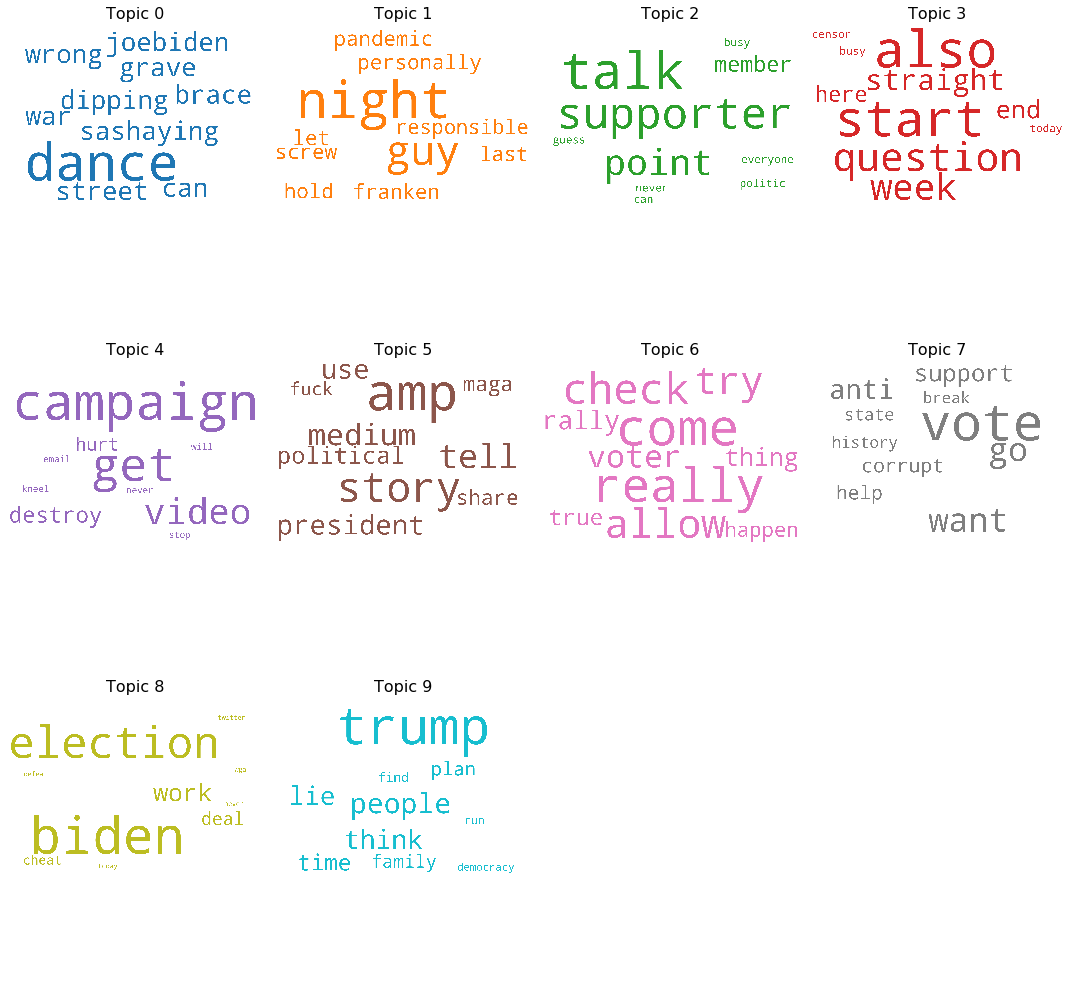

In [40]:
# Word Cloud plots
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 4, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i < len(topics):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=500)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')
    else:
        ax.axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()